In [2]:
import os
# import torch
import numpy as np
import pandas as pd
# from torch.utils.data import Dataset
import fitz
from tqdm import tqdm
import re

In [2]:
main_path = 'Дата-сет для задачи №1\\Разметка\\'

In [3]:
full_data = pd.read_csv('Дата-сет для задачи №1\\Дата-сет_Задача 1.csv', sep=';', encoding="windows-1251")

In [3]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100425 entries, 0 to 100424
Data columns (total 5 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   Номер_в_госреестре              100416 non-null  object 
 1   Наименование_СИ                 99851 non-null   object 
 2   Единица_измерения_СИ            0 non-null       float64
 3   Погрешность_СИ                  0 non-null       float64
 4   Наименование_файла_с_описанием  51694 non-null   object 
dtypes: float64(2), object(3)
memory usage: 3.8+ MB


In [4]:
#

have_file_df = full_data[(full_data['Наименование_файла_с_описанием'].notna())]
print(have_file_df.shape)
test_files = os.listdir('Дата-сет для задачи №1\\Разметка')
print(len(test_files))
answer_df = full_data[full_data['Наименование_файла_с_описанием'].isin(test_files)]
print(answer_df.shape)
answer_df = answer_df.drop_duplicates(['Наименование_файла_с_описанием'])
print(answer_df.shape)

(51694, 5)
1106
(895, 5)
(886, 5)


In [6]:
answer_df.to_csv('answer_df.csv')

In [6]:
file_names=[]
for i in range(answer_df.shape[0]):
    name = answer_df['Наименование_файла_с_описанием'].iloc[i]
    if os.path.exists(f'Дата-сет для задачи №1\\Разметка\\{name}'):
        file_names.append(f'Дата-сет для задачи №1\\Разметка\\{name}')

In [7]:
file_small_names = [name.split('\\')[-1] for name in file_names]
with open('file_small_names.txt', 'w') as f:
    for item in file_small_names:
        f.write("%s\n" % item)


### PDF HIGHLIGHTS READER

In [72]:
# new_data_dict = {}
# data_dict = {}
# for file_name in tqdm(file_names):
#     # list to store the co-ordinates of all highlights
#     highlights = []
#     # List to store all the highlighted texts
#     highlight_text = []
#     # read file
#     doc = fitz.open(file_name)
#     page_count = doc.page_count
#     for n in range(page_count):
#         # load page
#         page = doc.load_page(n)
#         # annot generator
#         annot = page.firstAnnot
#         # loop till we have highlight annotation in the page
#         while annot:
#             if annot.type[0] == 8:
#                 all_coordinates = annot.vertices
#                 if len(all_coordinates) == 4:
#                     highlight_coord = fitz.Quad(all_coordinates).rect
#                     highlights.append(highlight_coord)
#                 else:
#                     all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
#                     for i in range(0,len(all_coordinates)):
#                         coord = fitz.Quad(all_coordinates[i]).rect
#                         highlights.append(coord)
#             annot = annot.next

#         # all words from page
#         all_words = page.get_text_words()
        
#         for h in highlights:
#             sentence = [w[4] for w in all_words if fitz.Rect(h).intersects(w[0:4])]
#             highlight_text.append(" ".join(sentence))    

#         data_dict[file_name] = highlight_text
#         new_data_dict[file_name.split('\\')[-1]] = highlight_text

100%|██████████| 886/886 [03:36<00:00,  4.08it/s]


In [64]:
def parse_pdf(file_name):
    '''
    Из всего пдф файла парсит highlights и возвращает текст и цвет
    '''
    # List to store all the highlighted texts
    highlight_text = []
    # read file
    doc = fitz.open(file_name)
    page_count = doc.page_count
    for n in range(page_count):
        # list to store the co-ordinates of all highlights
        highlights = []
        # load page
        page = doc.load_page(n)
        # annot generator
        annot = page.firstAnnot
        # loop till we have highlight annotation in the page
        while annot:
            if annot.type[0] == 8:
                all_coordinates = annot.vertices
                if len(all_coordinates) == 4:
                    highlight_coord = fitz.Quad(all_coordinates).rect
                    highlights.append((highlight_coord, annot.colors))

                else:
                    all_coordinates = [all_coordinates[x:x+4] for x in range(0, len(all_coordinates), 4)]
                    for i in range(0,len(all_coordinates)):
                        coord = fitz.Quad(all_coordinates[i]).rect
                        highlights.append((coord, annot.colors))
            annot = annot.next

        # all words from page
        all_words = page.get_text_words()
        highlights = sorted(highlights, key=lambda x: tuple(x[0])[1])
        for h in highlights:
            sentence = [w[4] for w in all_words if fitz.Rect(h[0]).intersects(w[0:4])]
            highlight_text.append((" ".join(sentence), h[1]))
        
    return highlight_text

In [78]:
def create_pdf_dict(highlight_text):
    def color_define(tup):
        if tup[2] > 0.9:
            return 'error'
        if tup[0] > 0.9:
            return 'name'
        else:
            return 'unit'

    my_dict = {'name': [], 'unit': [], 'error': []} # одна пдфка
    for i in highlight_text:
        my_dict[color_define(i[1]['stroke'])].append(i[0])
    for key in my_dict:
        my_dict[key] = ' '.join(my_dict[key])
    
    return my_dict


In [291]:
data = []
for file_name in tqdm(os.listdir(main_path)): #для обучения на пересекающейся выборке file_small_names
    tmp_dict = create_pdf_dict(parse_pdf(main_path+file_name))
    tmp_dict['file_name'] = file_name
    data.append(tmp_dict)
df = pd.DataFrame(data)

100%|██████████| 1106/1106 [02:07<00:00,  8.64it/s]


In [292]:
df['true_unit'] = df['unit'].str.extract(r"(, [°СА-я1-9]+)")
df.true_unit = df.true_unit.str.slice(2)

# Обработка Диапазон
str_diap_idx = df[df.true_unit.isin(['Диапазон'])].index
df.loc[str_diap_idx, 'unit'] = df.loc[str_diap_idx, 'unit'] + ' '
tmp_df = df[df.true_unit.isin(['Диапазон'])].unit.str.extract(r"(, [°СА-я•]{1,3}[1-9]? )")
df.loc[str_diap_idx, 'true_unit'] = tmp_df[0].str.slice(2,-1).values

# Обработка измерений, измерения
str_diap_idx = df[df.true_unit.isin(['измерений', 'измерения'])].index
df.loc[str_diap_idx, 'unit'] = df.loc[str_diap_idx, 'unit'] + ' '
tmp_df = df[df.true_unit.isin(['измерений', 'измерения'])].unit.str.extract(r"(, [°СА-я•]{1,5}[1-9]? )")
df.loc[str_diap_idx, 'true_unit'] = tmp_df[0].str.slice(2,-1).values

# Обработка Пределы
str_diap_idx = df[df.true_unit.isin(['Пределы'])].index
tmp_df = df[df.true_unit.isin(['Пределы'])].unit.str.extract(r"([°СА-я•]{1,3}[1-9]?)")
df.loc[str_diap_idx, 'true_unit'] = tmp_df[0].values

In [303]:
df.to_csv('unit_train_df.csv')

In [71]:
# Мой датафрейм
df = {i: list(item) for i, item in enumerate(data_dict.items())}
df = pd.DataFrame.from_dict(df, orient='index', columns=['file_name', 'text'])


In [73]:
# Общий датафрейм
df = {i: list(item) for i, item in enumerate(new_data_dict.items())}
df = pd.DataFrame.from_dict(df, orient='index', columns=['file_name', 'text'])
df.to_csv('train_df.csv')

### PDF Full texts for classification

In [300]:
data_dict = {}
for file_name in tqdm(os.listdir(main_path)):
        text=''
        doc = fitz.open(main_path + file_name)
        page_count = doc.page_count
        for n in range(page_count):
                page = doc.load_page(n)
                text += page.get_text()
        data_dict[file_name] = text


100%|██████████| 1106/1106 [01:07<00:00, 16.30it/s]


In [301]:
pdf_df = {i: list(item) for i, item in enumerate(data_dict.items())}
pdf_df = pd.DataFrame.from_dict(pdf_df, orient='index', columns=['file_name', 'text'])
pdf_df.to_csv('full_train_df.csv')

In [304]:
pdf_df

,file_name,text
0,2005-30815-05.pdf,Трансформатор напряжения эталонный\nмобильный ...
1,2008-01054-08.pdf,
2,2008-27361-04.pdf,Счетчики скоростные крыльчатые\nхолодной и гор...
3,2008-34048-08.pdf,Счетчики активной\nэлектрической энергии трехф...
4,2008-34291-07.pdf,Внесены в Государственный реестр\nсредств изме...
...,...,...
1101,2021-82991-21.pdf,УТВЕРЖДЕНО \nприказом Федерального агентства \...
1102,2021-83010-21.pdf,УТВЕРЖДЕНО \nприказом Федерального агентства \...
1103,2021-83333-21.pdf,\nУТВЕРЖДЕНО \nприказом Федерального агентств...
1104,2021-83360-21.pdf,\nУТВЕРЖДЕНО \nприказом Федерального агентств...


### data_union

In [17]:
answer_df = pd.read_csv('filled_answer.csv', index_col=0)
data2_path = 'Дата-сет для задачи №2\\'
file_names = os.listdir('Дата-сет для задачи №1\Разметка')
data2_full = []
for csv_file in tqdm(os.listdir(data2_path)):
    try:
        tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')       
        data2_full.append(tmp_df[tmp_df['Наименование_файла_с_описанием'].isin(file_names)])
    except:
        print(csv_file)

data2_full=pd.concat(data2_full)

  6%|▌         | 34/573 [01:56<30:48,  3.43s/it]

034 AoEqMS0xOTUyMDcyMQ==.csv


  7%|▋         | 40/573 [02:13<21:22,  2.41s/it]

040 AoEqMS0yMjIzNjkyNw==.csv


  8%|▊         | 46/573 [02:33<24:20,  2.77s/it]

046 AoEqMS0yNDk0MjkyNw==.csv


  9%|▊         | 49/573 [02:41<23:03,  2.64s/it]

049 AoEqMS0yNjMwMDU2Mg==.csv


 10%|█         | 60/573 [03:22<30:57,  3.62s/it]

060 AoEqMS0zMTMwNTY5Ng==.csv


 14%|█▍        | 79/573 [04:36<24:46,  3.01s/it]

079 AoEoMS0zOTk1NzM=.csv


 16%|█▌        | 93/573 [05:28<29:38,  3.71s/it]

093 AoEqMS00NjM3MDY5Mw==.csv


 17%|█▋        | 99/573 [05:50<28:08,  3.56s/it]

099 AoEqMS00OTEwMzEzNQ==.csv


 18%|█▊        | 104/573 [06:10<31:43,  4.06s/it]

104 AoEqMS01MTM2Mjg2Mg==.csv


 19%|█▉        | 110/573 [06:46<45:12,  5.86s/it]

110 AoEqMS01NDA3MDg3MQ==.csv


 38%|███▊      | 218/573 [13:35<13:55,  2.35s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 38%|███▊      | 219/573 [13:44<25:01,  4.24s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 39%|███▊      | 221/573 [13:48<19:10,  3.27s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 40%|████      | 231/573 [14:20<18:26,  3.23s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWa

275 AoErMi0xMjg4MzkwODY=.csv


C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 48%|████▊     | 277/573 [16:42<12:55,  2.62s/it]

277 AoErMi0xMjk3MzkwODY=.csv


 49%|████▊     | 278/573 [16:43<09:45,  1.98s/it]

278 AoErMi0xMzAxODkwODg=.csv


 49%|████▊     | 279/573 [16:47<12:54,  2.64s/it]

279 AoErMi0xMzA2MzkwOTE=.csv


 49%|████▉     | 283/573 [17:00<14:36,  3.02s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 50%|████▉     | 284/573 [17:03<14:52,  3.09s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 50%|████▉     | 286/573 [17:09<14:12,  2.97s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 50%|█████     | 288/573 [17:13<12:09,  2.56s/it]

288 AoErMi0xMzQ2ODkxOTM=.csv


 51%|█████     | 290/573 [17:16<08:17,  1.76s/it]

289 AoErMi0xMzUxMzkyMDE=.csv
290 AoErMi0xMzU1ODkyMDI=.csv


 51%|█████     | 291/573 [17:17<07:28,  1.59s/it]

291 AoErMi0xMzYwMzkyMTQ=.csv


 51%|█████     | 292/573 [17:17<05:41,  1.21s/it]

292 AoErMi0xMzY0ODkyMTc=.csv


 51%|█████     | 293/573 [17:18<04:25,  1.06it/s]

293 AoErMi0xMzY5MzkyMjU=.csv


 51%|█████▏    | 294/573 [17:18<04:00,  1.16it/s]

294 AoErMi0xMzczODkyMjk=.csv


 51%|█████▏    | 295/573 [17:19<03:28,  1.34it/s]

295 AoErMi0xMzc4MzkyMzQ=.csv


 52%|█████▏    | 296/573 [17:19<02:49,  1.64it/s]

296 AoErMi0xMzgyODkyMzk=.csv


 52%|█████▏    | 297/573 [17:19<02:22,  1.94it/s]

297 AoEqMi0xMzg3MzkyNA==.csv


 52%|█████▏    | 298/573 [17:20<02:35,  1.77it/s]

298 AoErMi0xMzkxODkyNDU=.csv


C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 52%|█████▏    | 300/573 [17:28<11:14,  2.47s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 53%|█████▎    | 305/573 [17:46<15:20,  3.43s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 53%|█████▎    | 306/573 [17:49<14:20,  3.22s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtyp

322 AoErMi0xNDk5ODkzODg=.csv


 56%|█████▋    | 323/573 [18:50<09:27,  2.27s/it]

323 AoEqMi0xNTA0Mzk0MA==.csv


 57%|█████▋    | 325/573 [18:55<09:17,  2.25s/it]

325 AoEqMi0xNTEzMzk1MA==.csv


 57%|█████▋    | 326/573 [18:57<08:30,  2.07s/it]

326 AoEqMi0xNTE3ODk2MQ==.csv


 58%|█████▊    | 330/573 [19:08<09:15,  2.29s/it]

330 AoErMi0xNTM1ODk2NjU=.csv


 60%|██████    | 345/573 [20:03<12:51,  3.39s/it]

345 AoErMi0xNjAzMzk5NDc=.csv


 61%|██████    | 349/573 [20:18<12:52,  3.45s/it]

349 AoErMi0xNjIxNDAwMjI=.csv


 62%|██████▏   | 358/573 [20:48<11:05,  3.09s/it]

358 AoErMi0xNjYxOTA2OTc=.csv


 63%|██████▎   | 362/573 [21:04<13:32,  3.85s/it]

362 AoErMi0xNjc5OTA5Mzk=.csv


 64%|██████▎   | 365/573 [21:14<11:46,  3.40s/it]

365 AoErMi0xNjkzNDA5OTY=.csv


 65%|██████▌   | 374/573 [21:45<10:27,  3.15s/it]

374 AoErMi0xNzMzOTE4Mzc=.csv


 66%|██████▌   | 377/573 [21:56<09:59,  3.06s/it]

377 AoErMi0xNzQ3NDE4NDk=.csv


 66%|██████▋   | 380/573 [22:07<11:37,  3.61s/it]

380 AoErMi0xNzYwOTIwNDc=.csv


 68%|██████▊   | 387/573 [22:32<09:19,  3.01s/it]

387 AoEqMi0xNzkyNDgxOA==.csv


 68%|██████▊   | 389/573 [22:38<09:09,  2.99s/it]

389 AoErMi0xODAxNDgzNTM=.csv


 68%|██████▊   | 390/573 [22:41<09:14,  3.03s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 74%|███████▎  | 422/573 [23:29<03:54,  1.56s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 74%|███████▍  | 425/573 [23:33<03:39,  1.48s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 75%|███████▍  | 429/573 [23:39<03:36,  1.51s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWa

457 AoEqMi00NzU1NTczMw==.csv


 80%|████████  | 461/573 [24:45<04:06,  2.20s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 81%|████████  | 462/573 [24:47<04:04,  2.20s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 81%|████████  | 463/573 [24:49<03:53,  2.12s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')

 82%|████████▏ | 468/573 [24:59<03:23,  1.94s/it]C:\Users\ptmeg\AppData\Local\Temp\ipykernel_396\3559771164.py:7: DtypeWa

In [18]:
data2_full.to_csv('data2_full.csv')

In [1]:
data2_full.head()

NameError: name 'data2_full' is not defined

In [ ]:
answer_df = pd.read_csv('filled_answer.csv', index_col=0)
data2_path = 'Дата-сет для задачи №2\\'
file_names = os.listdir('Дата-сет для задачи №1\Разметка')
data2_full = []
for csv_file in tqdm(os.listdir(data2_path)):
    try:
        tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')       
        data2_full.append(tmp_df[tmp_df['Наименование_файла_с_описанием'].isin(file_names)])
    except:
        print(csv_file)

data2_full=pd.concat(data2_full)

In [23]:
answer_df = pd.read_csv('filled_answer.csv', index_col=0)
data2_path = 'Дата-сет для задачи №2\\'
file_names = os.listdir('Дата-сет для задачи №1\Разметка')
data2_full = []
columns_orig = pd.read_csv(data2_path+os.listdir(data2_path)[2], sep=';', encoding='windows-1251').columns
k=0
for csv_file in tqdm(os.listdir(data2_path)):
    try:
        tmp_df = pd.read_csv(data2_path+csv_file, sep=';', encoding='windows-1251')       
        if set(tmp_df.columns) != set(columns_orig):
            continue
        data2_full.append(tmp_df[tmp_df['Наименование_файла_с_описанием'].isin(file_names)])
        k += 1
        print('k  ', k)
        if k == 10:
            break
    except:
        print(csv_file)

data2_full=pd.concat(data2_full)

  0%|          | 2/573 [00:05<28:22,  2.98s/it]

k   1


  1%|          | 3/573 [00:08<28:04,  2.96s/it]

k   2


  1%|          | 4/573 [00:11<27:59,  2.95s/it]

k   3


  1%|          | 5/573 [00:15<28:38,  3.03s/it]

k   4


  1%|          | 6/573 [00:18<29:10,  3.09s/it]

k   5


  1%|          | 7/573 [00:21<28:45,  3.05s/it]

k   6


  2%|▏         | 9/573 [00:26<27:50,  2.96s/it]

k   7


  2%|▏         | 10/573 [00:29<27:28,  2.93s/it]

k   8


  2%|▏         | 11/573 [00:32<27:31,  2.94s/it]

k   9


  2%|▏         | 11/573 [00:35<30:30,  3.26s/it]

k   10


In [24]:
data2_full.to_csv('sample_data2_full.csv')
data2_full = pd.read_csv('sample_data2_full.csv', index_col=0)
data2_full.reset_index(drop=True, inplace=True)
data2_full.info()
answ2_data = data2_full.drop(columns='Единица_измерения_СИ').merge(answer_df[['Наименование_файла_с_описанием','Номер_в_госреестре', 'Единица_измерения_СИ']],
                            how='left',
                            on=['Наименование_файла_с_описанием', 'Номер_в_госреестре'])
cols = set(answ2_data.columns) - {'Дата_поверки_СИ'}
answ2_data = answ2_data.sort_values(by='Дата_поверки_СИ').drop_duplicates(cols)
grouped_data = answ2_data.groupby('Единица_измерения_СИ').agg({'Производитель_СИ':lambda x: list(x)})
grouped_data
def mother_market_parts(comp_list):
    mother_comps=0
    for comp in comp_list:
        if len(re.findall("([А-я])", comp)) / (len(re.findall("([A-z])", comp)) + 1e-4) > 1:
            mother_comps += 1
    return mother_comps / len(comp_list)

result = grouped_data['Производитель_СИ'].apply(mother_market_parts)

In [69]:
result

Единица_измерения_СИ
°С    0.767677
А     0.595745
В     0.351064
г     0.160000
кВ    1.000000
кг    0.285714
м     0.873950
м3    0.837607
мм    0.412913
т     0.776042
Name: Производитель_СИ, dtype: float64

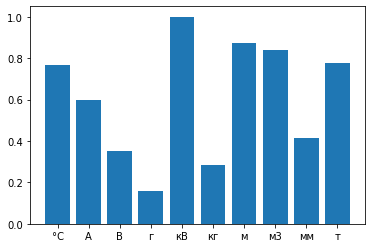

In [70]:
import matplotlib.pyplot as plt
plt.bar(np.arange(len(result)), result.values)
plt.xticks(np.arange(len(result)), result.index)
plt.show()